<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT22/blob/GHusername1_lab1/Lab1/GHusername1_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

0.4


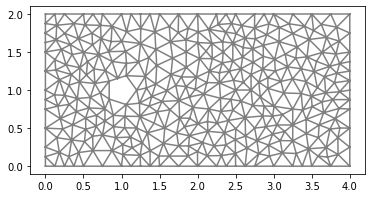

In [ ]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2      # can change rc to change Re
D = 2*rc 
print(D)

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 16 # test h=1/8, 1/16, 1/32 (For Re=100)
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [ ]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)

# Changing Re by changing uin
#uin = 0.01
#uin = 0.1
uin = 1.0
#uin = 10.0

bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [ ]:
# Set viscosity
nu = 4.0e-3
rho = 1
Re = (uin*D)/nu
print('Re =',Re)

#St1 = (0.5*D)/0.01       # f = no freq
#St10 = (0.5*D)/0.1       # f = no freq
St100 = (0.5*D)/1         # f = 0.5
St1000 = (5*D)/10         # f = 5
Sth16 = (0.4*D)/1         # f = 0.4

#print('Approx. St for Re1:',St1)
#print('Approx. St for Re10:',St10)
print('Approx. St for Re100:',St100)
print('Approx. St for Re1000:',St1000)
print('Approx. St for h=1/16:',Sth16)


Re = 100.0
Approx. St for Re100: 0.2
Approx. St for Re1000: 0.2
Approx. St for h=1/16: 0.16000000000000003


**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 
print(dt)

if uin == 10:
  dt = dt/2 # lowering dt for stability in Re1000 sol.
else:
  dt = dt
  
print(dt)

0.06628038350651762
0.06628038350651762


**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [ ]:
# Define the direction of the force to be computed 

# phi = (0,1) gives F_L, phi = (1,0) gives F_D
phi_x = 0.0
phi_y = 1.0
phi_x_D = 1.0
phi_y_D = 0.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)
Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

psi_expression_D = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x_D : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y_D : 0."), xc=xc, yc=yc, rc=rc, phi_x_D=phi_x_D, phi_y_D=phi_y_D, element = V.ufl_element())
psi_D = interpolate(psi_expression_D, V)
Force_D = inner((u1 - u0)/dt + grad(um1)*um1, psi_D)*dx - p1*div(psi_D)*dx + nu*inner(grad(um1), grad(psi_D))*dx


#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data 
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
cL_array = force_array

force_array_D = np.array(0.0)
force_array_D = np.delete(force_array_D, 0)
cD_array = force_array_D

time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Time t = 0.06628038350651762


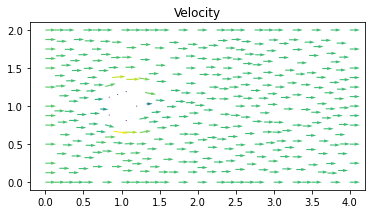

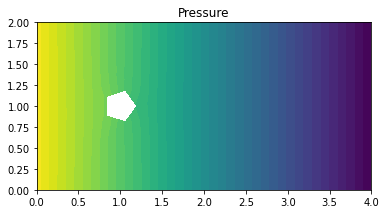

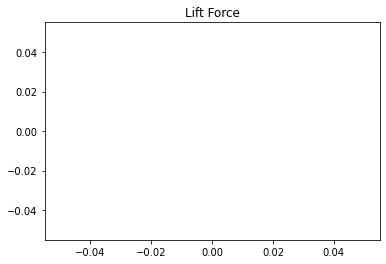

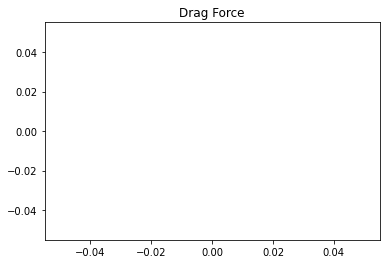

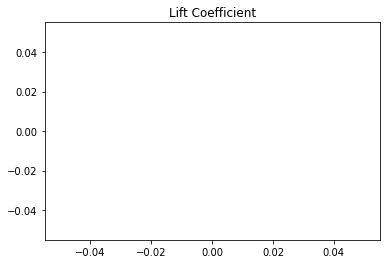

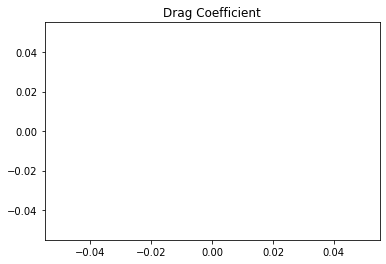

Time t = 3.0488976412998086


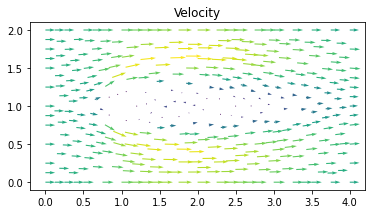

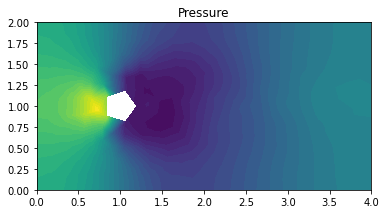

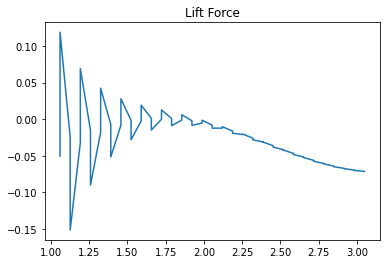

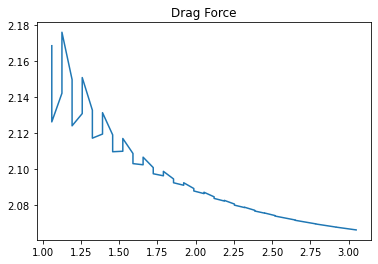

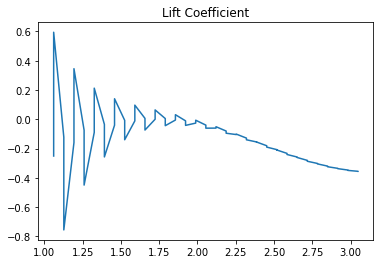

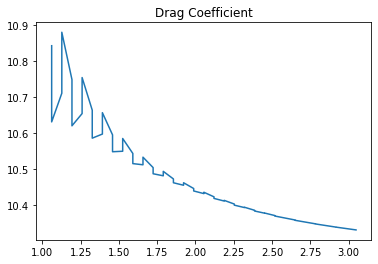

Time t = 6.031514899093112


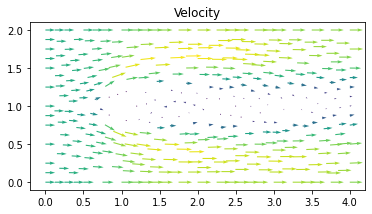

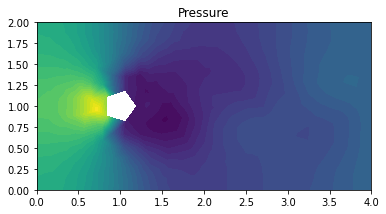

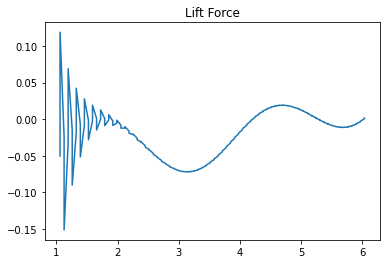

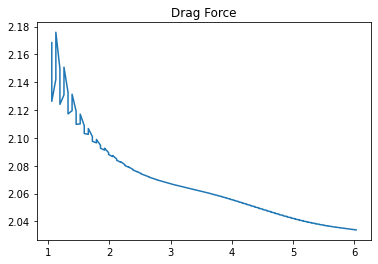

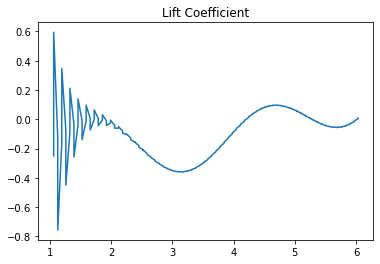

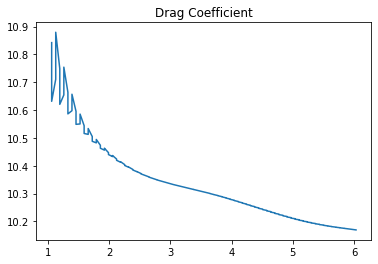

Time t = 9.01413215688642


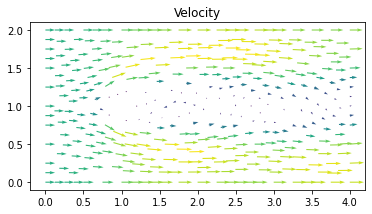

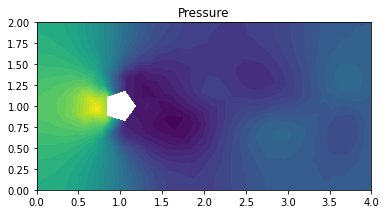

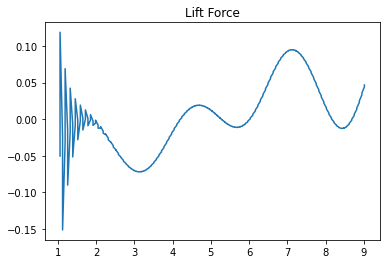

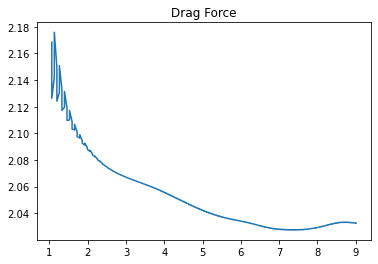

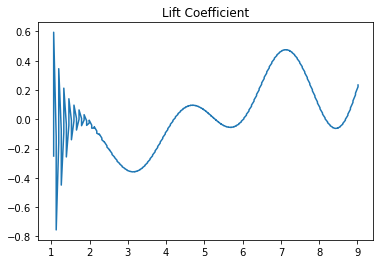

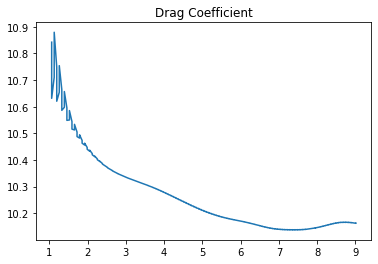

Time t = 12.063029798186248


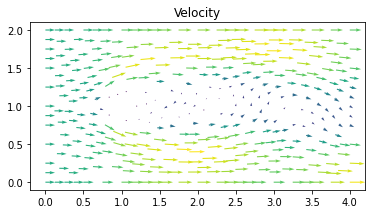

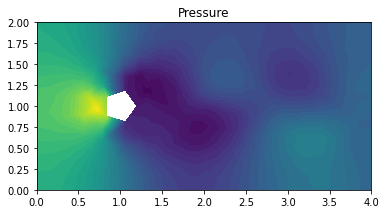

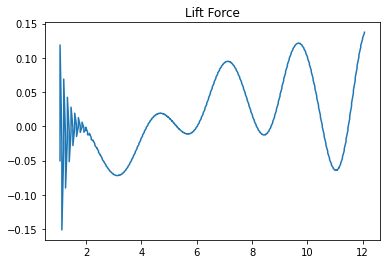

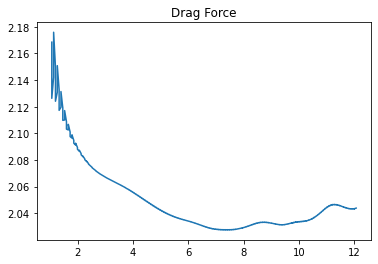

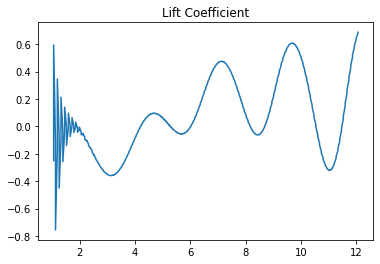

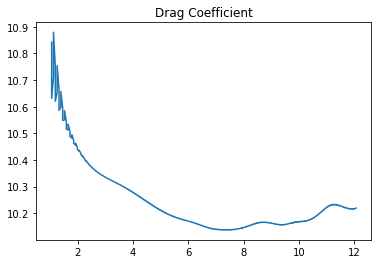

Time t = 15.045647055979558


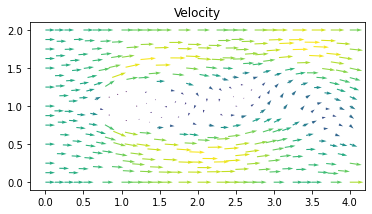

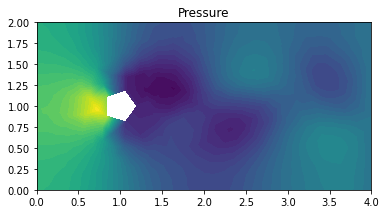

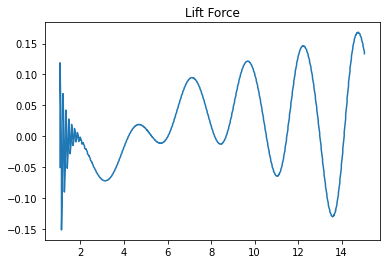

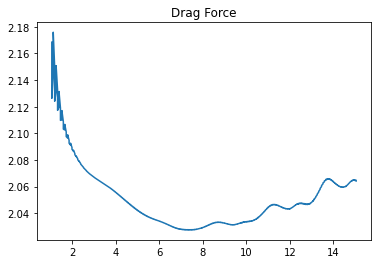

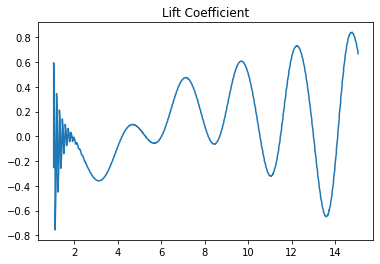

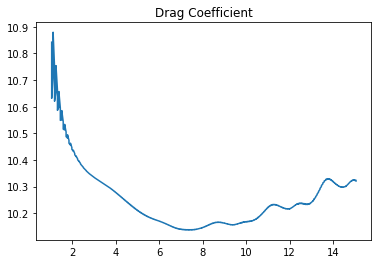

Time t = 18.028264313772812


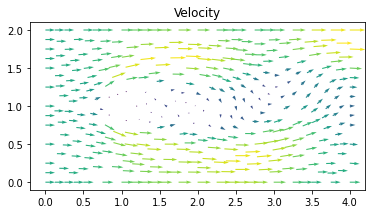

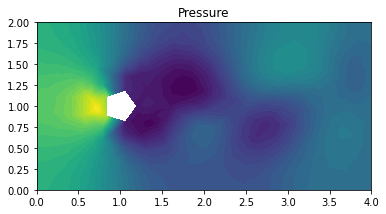

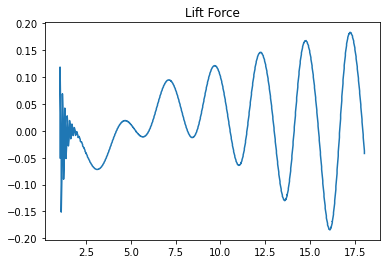

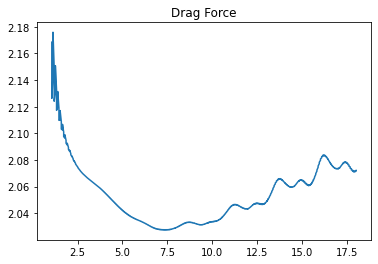

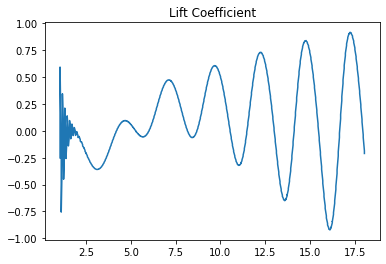

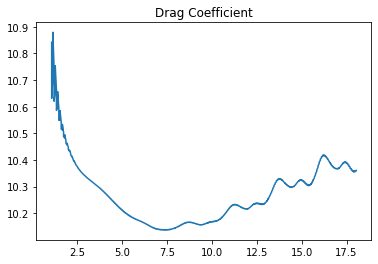

Time t = 21.010881571566042


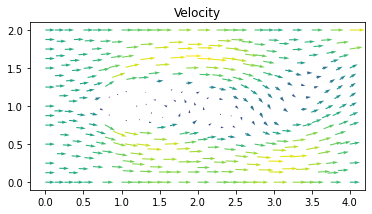

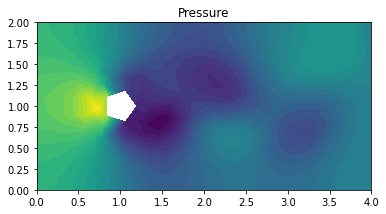

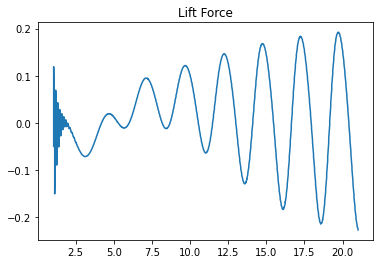

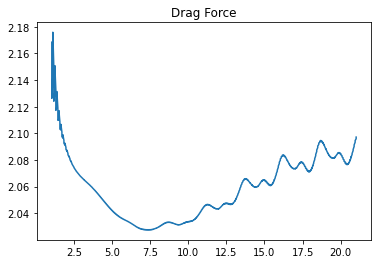

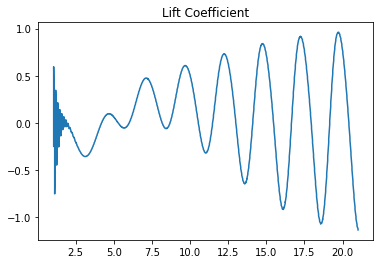

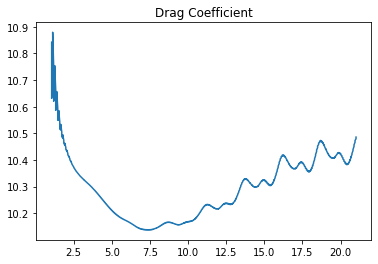

Time t = 24.059779212865788


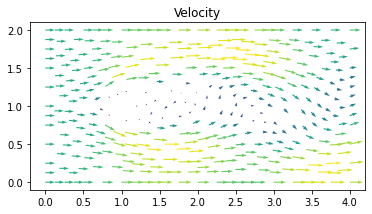

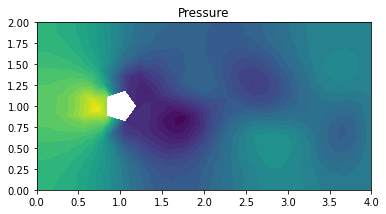

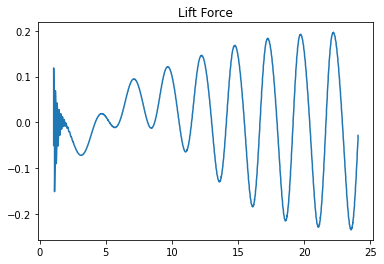

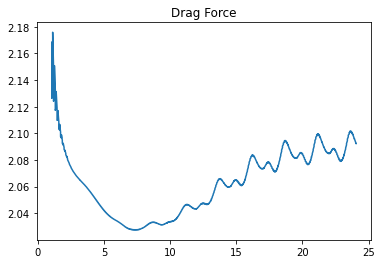

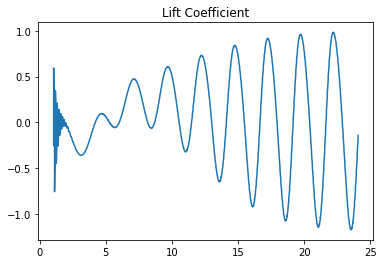

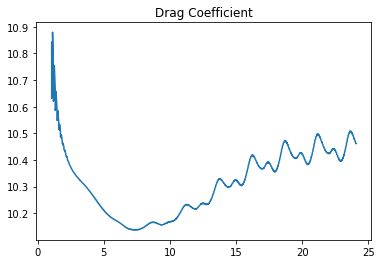

Time t = 27.042396470659018


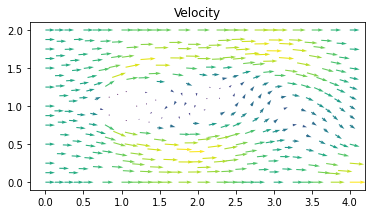

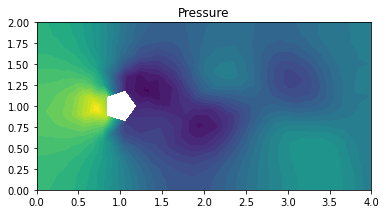

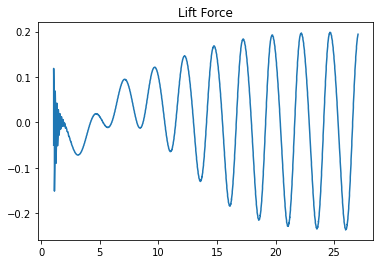

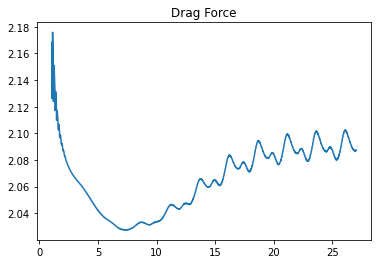

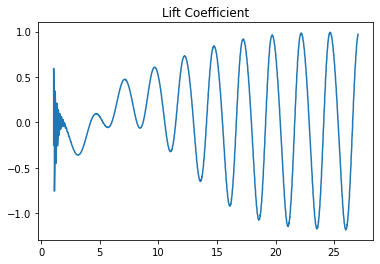

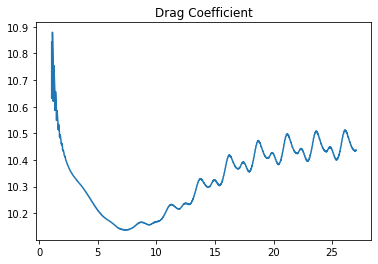

In [ ]:
!rm results-NS/*

# Time stepping 
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        F_D = assemble(Force_D)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          cL_array = (2/(rho*(uin**2)*D))*force_array

          force_array_D = np.append(force_array_D, normalization*F_D)
          cD_array = (2/(rho*(uin**2)*D))*force_array_D

          time = np.append(time, t)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq
        
        plt.show()

        plt.figure()
        plt.title("Lift Force")
        plt.plot(time, force_array)

        plt.figure()
        plt.title("Drag Force")
        plt.plot(time, force_array_D)

        plt.show()

        plt.figure()
        plt.title("Lift Coefficient")
        plt.plot(time, cL_array)

        plt.figure()
        plt.title("Drag Coefficient")
        plt.plot(time, cD_array)

        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)

The Reynolds number was adjusted by changing the inflow velocity to values in the range [0.01, 0.1, 1, 10] to generate Reynolds numbers in the range [1, 10, 100, 100].

The generated solution for Re = 1 and Re = 10 gave stable solutions with no von Karman vortex streets and therefore the Strouhal number is zero in both cases since the vortex shedding frequancy is zero. The computed drag and lift coefficients converge towards cD = 110, cL = 0.7 for Re = 1 and cD = 18, cL = 0.28 for Re = 10.

When the problem is solved with Re = 100 (and h = 1/32) a von Karman vortex street is formed with a shedding frequency of approximately 0.5 Hz which yields a Strouhal number of 0.2. 

Increasing the Reynolds number to Re = 1000 will generate an unstable solution with a von Karman vortex street that grows over time. In the beginning the vortex shedding frequency is approximately 5 Hz which again yields a Strouhal number of St = 0.2.

When changing the resolution to h = 1/8 (with Re = 100) the generated mesh is of a very low resolution. The solution becomes stable with the von Karman vortex street disaperaing over time. In this case the drag and lift coefficient converges to cD = 14.9 and cL = -0.3.

For h = 1/16 a vortex street is formed with a shedding frequency of f = 0.4 which yields a Strouhal number of St = 0.16. The drag and lift coeffients are ocillating between cd = (10.5, 10.4) and cL = (1, -1).

